In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
complexity_columns = ['X', 'Y', 'Z', 'NTG', 'Number_of_intervals', 'Lateral_Heterogenity']
scrutiny_columns = ['X', 'Y', 'Z', 'Seismica', 'GIS', 'Kern', 'Fluid', 'Perforation', 'WTA']
grid_std_columns = ['X', 'Y', 'h', 'Column', 'Row']
grid_mean_columns = ['X', 'Y', 'mean', 'Column', 'Row']
std_mean_columns = ['X', 'Y', 'Z', 'std', 'mean']
mean_test_columns = ['X', 'Y', 'Z', 'mean']


def read_file(name, skip, columns):
    """Read file, parse it into pandas dataframe

    :param name: filename
    :param skip: number of rows to skip
    :param columns: column names
    :return: obtained dataframe
    """
    data = pd.read_csv(name, sep=' ', skiprows=skip, header=None)
    data.dropna(axis=1, inplace=True)
    data.columns = columns
    return data

level_of_complexity86_train = read_file("Level_of_complexity_train.txt", 12, complexity_columns)
level_of_scrutiny86_train = read_file("Level_of_scrutiny_train.txt", 15, scrutiny_columns)
std_mean76_train = read_file("ThickEff_wells", 11, std_mean_columns)

grid_std_train = pd.read_csv("Target_std_train.txt", sep=' ', skiprows=20, header=None, names=grid_std_columns)
grid_std_train.drop_duplicates(subset=['X', 'Y'], inplace=True)
grid_mean_train = pd.read_csv("ThickEff_mean", skiprows=20, sep=' ', header=None, names=grid_mean_columns)
grid_mean_train.drop_duplicates(subset=['X', 'Y'], inplace=True)

level_of_complexity25_test = read_file("Level_of_complexity_test.txt", 12, complexity_columns)
level_of_scrutiny25_test = read_file("Level_of_scrutiny_test.txt", 15, scrutiny_columns)

def parse(filename, cols):
    df = pd.read_csv(filename, skiprows=9, sep='\t')
    df = df.applymap(lambda row: row.split(' ')[:4])
    for i, col in enumerate(cols):
        df[col] = df['END HEADER'].apply(lambda row: row[i]).values
    df.drop(columns='END HEADER', inplace=True)
    return df

mean25_test = parse("Well_heff", mean_test_columns)

grid_mean_test = pd.read_csv("Map_Heff", skiprows=20, sep=' ', header=None, names=grid_mean_columns)

In [4]:
scrutiny_complexity86_train = level_of_scrutiny86_train.merge(level_of_complexity86_train, how='left', on=['X', 'Y', 'Z'])
scrutiny_complexity86_train.head(5)

,X,Y,Z,Seismica,GIS,Kern,Fluid,Perforation,WTA,NTG,Number_of_intervals,Lateral_Heterogenity
0,344908.11,6395171.35,0.0,1.0,0.694,0.0,0.0,0.000,0.000,4.028,4.028,4.028
1,346337.37,6394899.20,0.0,1.0,0.706,0.0,0.0,0.000,0.000,3.976,3.976,3.976
2,345857.77,6392425.56,0.0,1.0,0.775,0.0,0.0,0.065,0.000,4.018,4.018,4.018
3,346768.65,6392536.12,0.0,1.0,0.828,0.0,0.0,0.000,0.000,4.984,4.984,4.984
4,345900.31,6390944.48,0.0,1.0,0.672,0.0,0.0,0.000,0.002,3.969,3.969,3.969


In [5]:
std_mean76_train.head()

,X,Y,Z,std,mean
0,344908.11,6395171.35,0.0,0.528,1.382
1,346337.37,6394899.20,0.0,1.025,12.306
2,345857.77,6392425.56,0.0,1.991,11.498
3,346768.65,6392536.12,0.0,0.658,2.487
4,345900.31,6390944.48,0.0,1.050,12.352


In [6]:
def interpolate_scrutiny_to_grid(model, params, level_of_scrutiny, X_test):
    """Interpolate [Seismica, GIS, Kern, Fluid, Perforation, WTA, complexities] to grid

    :param model: model to train
    :param params: model parameters grid
    :param level_of_scrutiny: training set containing points and their labels
    :param X_test: test set containing grid of points
    :return: dataframe of grid points and their labels, array of trained models
    """
    df_scrutiny_grid, mas_of_models = X_test.copy(), []
    
    X_train = level_of_scrutiny.iloc[:, [0, 1]]
    for i in range(3, len(level_of_scrutiny.columns)):
        y_train = level_of_scrutiny.iloc[:, i]
        searcher = GridSearchCV(model, params, verbose=1, cv=5)
        searcher.fit(X_train, y_train)
        y_pred = searcher.best_estimator_.predict(X_test)
        mas_of_models.append(searcher.best_params_)
        df_scrutiny_grid[level_of_scrutiny.columns.values[i]] = y_pred

    return df_scrutiny_grid, mas_of_models

In [7]:
def get_otv_given_df_scrutiny_grid(model, params, df_scrutiny_grid, std_target):
    """Train model with given train features and labels
    
    :param model: model to train
    :param params: model parameters
    :param df_scrunity_grid: features
    :param std_target: labels
    :return: trained model
    """
    searcher = GridSearchCV(model, params, n_jobs=1, verbose=3, cv=5)
    searcher.fit(df_scrutiny_grid, std_target)
    std_pred = searcher.best_estimator_.predict(df_scrutiny_grid)
    print(((std_pred-std_target)**2).mean())
    return searcher.best_estimator_

In [8]:
model = ElasticNet()
params = {
    'alpha': [1e-2, 1e-1, 1],
    'l1_ratio': [1e-2, 1e-1, 1],
    'normalize': [True]
}

df_features_on_grid_from_grid_mean_train, mas_of_models = interpolate_scrutiny_to_grid(model, params,\
                                                                                       scrutiny_complexity86_train, grid_mean_train.iloc[:, :2])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.2s finished


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.2s finished


In [9]:
df_features_with_mean_on_grid_from_grid_mean_train = df_features_on_grid_from_grid_mean_train.merge(grid_mean_train, how='inner', on=['X', 'Y'])
df_features_with_mean_on_grid_from_grid_mean_train.drop(columns=['Column', 'Row'], inplace=True)

In [10]:
df_features_with_mean_on_grid_from_grid_mean_train.head()

,X,Y,Seismica,GIS,Kern,Fluid,Perforation,WTA,NTG,Number_of_intervals,Lateral_Heterogenity,mean
0,343755.868337,6.380209e+06,1.0,0.71714,0.122533,0.02514,0.053608,0.026047,4.195593,4.195593,4.195593,0.0
1,343803.709016,6.380224e+06,1.0,0.71714,0.123078,0.02514,0.053579,0.026047,4.195593,4.195593,4.195593,0.0
2,343851.549696,6.380238e+06,1.0,0.71714,0.123624,0.02514,0.053549,0.026047,4.195593,4.195593,4.195593,0.0
3,343899.390375,6.380253e+06,1.0,0.71714,0.124169,0.02514,0.053520,0.026047,4.195593,4.195593,4.195593,0.0
4,343947.231054,6.380267e+06,1.0,0.71714,0.124715,0.02514,0.053490,0.026047,4.195593,4.195593,4.195593,0.0


In [11]:
np.unique(df_features_with_mean_on_grid_from_grid_mean_train.iloc[:, 4])

array([-0.11505752, -0.11451217, -0.11433206, ...,  0.25705277,
        0.25723289,  0.25777823])

In [12]:
scrutiny_complexity_mean8676_train = scrutiny_complexity86_train.merge(std_mean76_train.drop(columns='Z'), how='left', on=['X', 'Y'])
std7686_train = scrutiny_complexity_mean8676_train.iloc[:, 12]
scrutiny_complexity_mean8676_train.drop(columns=['Z', 'std'], inplace=True)

train = pd.concat([scrutiny_complexity_mean8676_train.fillna(method='pad'), df_features_with_mean_on_grid_from_grid_mean_train])
target = pd.concat([std7686_train.fillna(method='pad'), grid_std_train.iloc[:, 2]])

In [13]:
model_next = RandomForestRegressor()
params_next = {
    'n_estimators': [100],
    'max_depth': [11]
}

clf = get_otv_given_df_scrutiny_grid(model_next, params_next, train, target)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=11, n_estimators=100 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... max_depth=11, n_estimators=100, score=0.899, total=  54.8s
[CV] max_depth=11, n_estimators=100 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.8s remaining:    0.0s


[CV] ...... max_depth=11, n_estimators=100, score=0.887, total= 1.2min
[CV] max_depth=11, n_estimators=100 ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


[CV] ...... max_depth=11, n_estimators=100, score=0.850, total=  54.0s
[CV] max_depth=11, n_estimators=100 ..................................
[CV] ...... max_depth=11, n_estimators=100, score=0.861, total= 2.2min
[CV] max_depth=11, n_estimators=100 ..................................
[CV] ...... max_depth=11, n_estimators=100, score=0.418, total= 2.3min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.6min finished


0.021925095716645592


In [15]:
filename = 'features_to_std.sav'
#pickle.dump(clf, open(filename, 'wb'))

clf_loaded = pickle.load(open(filename, 'rb'))

In [16]:
grid_mean_test.head()

,X,Y,mean,Column,Row
0,541124.357330,6.643889e+06,20.062500,320,150
1,541224.584105,6.643889e+06,19.333334,321,150
2,541024.130555,6.643989e+06,19.127531,319,151
3,541124.357330,6.643989e+06,18.900686,320,151
4,541224.584105,6.643989e+06,18.009216,321,151


In [18]:
scrutiny_complexity25_test = level_of_scrutiny25_test.merge(level_of_complexity25_test, how='left', on=['X', 'Y', 'Z'])

X_train = scrutiny_complexity25_test.iloc[:, [0, 1]]
X_test = grid_mean_test.iloc[:, [0, 1]]

df_features_on_grid_from_grid_mean_test = X_test.copy()

for i in range(3, len(scrutiny_complexity25_test.columns)):
    model = ElasticNet(**mas_of_models[i-3])
    model.fit(X_train, scrutiny_complexity25_test.iloc[:, i])
    y_pred = model.predict(X_test)
    df_features_on_grid_from_grid_mean_test[scrutiny_complexity25_test.columns.values[i]] = y_pred

test = df_features_on_grid_from_grid_mean_test.merge(grid_mean_test, how='inner', on=['X', 'Y']).drop(columns=['Column', 'Row'])
result = clf_loaded.predict(test)

In [19]:
df_features_on_grid_from_grid_mean_test.head()

,X,Y,Seismica,GIS,Kern,Fluid,Perforation,WTA,NTG,Number_of_intervals,Lateral_Heterogenity
0,541124.357330,6.643889e+06,0.7,0.300769,0.073019,0.080985,0.198659,0.0,3.615385,3.961538,2.461538
1,541224.584105,6.643889e+06,0.7,0.300769,0.073268,0.080985,0.199492,0.0,3.615385,3.961538,2.461538
2,541024.130555,6.643989e+06,0.7,0.300769,0.072828,0.082186,0.198062,0.0,3.615385,3.961538,2.461538
3,541124.357330,6.643989e+06,0.7,0.300769,0.073077,0.082186,0.198895,0.0,3.615385,3.961538,2.461538
4,541224.584105,6.643989e+06,0.7,0.300769,0.073326,0.082186,0.199728,0.0,3.615385,3.961538,2.461538


In [20]:
INF = 1e8

def distance(lhs_x, lhs_y, rhs_x, rhs_y):
    return np.sqrt((lhs_x - rhs_x) ** 2 + (lhs_y - rhs_y) ** 2)

def minimum_distance(pts_x, pts_y, pt_x, pt_y):
    answer = INF
    for i in range(len(pts_x)):
        dist = distance(pts_x[i], pts_y[i], pt_x, pt_y)
        if dist < answer:
            answer = dist
    return answer

def get_three_points(pts_x, pts_y, border=10000):
    cur_pts_x, cur_pts_y = [], []
    for i in range(len(pts_x)):
        if minimum_distance(cur_pts_x, cur_pts_y, pts_x[i], pts_y[i]) > border:
            cur_pts_x.append(pts_x[i])
            cur_pts_y.append(pts_y[i])
        if len(cur_pts_x) == 3:
            break
    return cur_pts_x, cur_pts_y

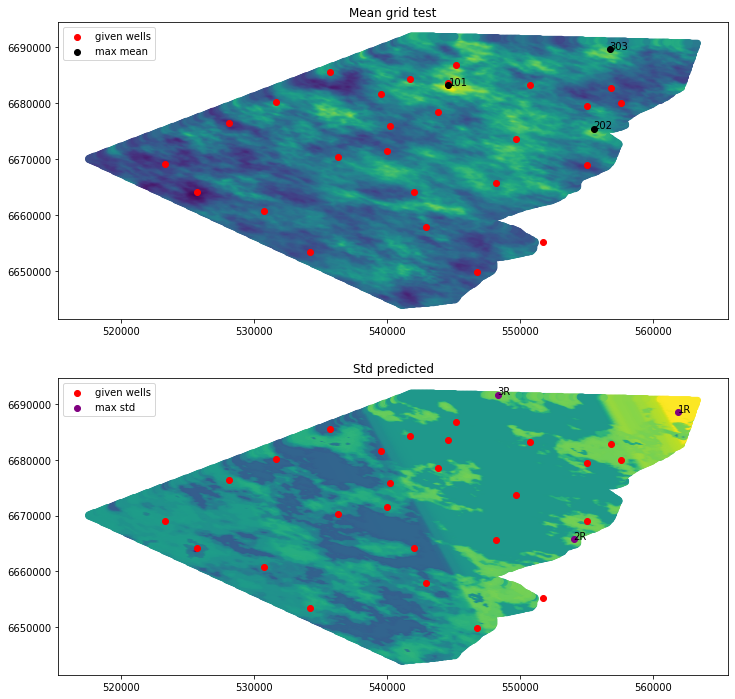

In [21]:
new_df = grid_mean_test
new_df['h_predicted'] = result
fig=plt.figure(figsize=(12,12))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

ax1.scatter(new_df["X"], new_df["Y"], c=new_df["mean"])
ax1.scatter(level_of_complexity25_test['X'],level_of_complexity25_test['Y'],color='red',label='given wells')
ax1.set_title('Mean grid test')
df_three_points=new_df.iloc[new_df['mean'].values.argsort()[::-1],:]
pts_x, pts_y = get_three_points(df_three_points['X'].values, df_three_points['Y'].values)
ax1.scatter(pts_x, pts_y, color='black', label='max mean')
ax1.legend()


for i in range(3):
    ax1.annotate('{}0{}'.format(i + 1, i + 1), (pts_x[i], pts_y[i]))

ax2.scatter(new_df["X"], new_df["Y"], c=new_df["h_predicted"])
ax2.scatter(level_of_complexity25_test['X'],level_of_complexity25_test['Y'],color='red',label='given wells')
df_three_points=new_df.iloc[result.argsort()[::-1],:]
pts_x, pts_y = get_three_points(df_three_points['X'].values, df_three_points['Y'].values)
ax2.scatter(pts_x, pts_y, color='purple', label='max std')

for i in range(3):
    ax2.annotate('{}R'.format(i + 1), (pts_x[i], pts_y[i]))

ax2.set_title('Std predicted')
ax2.legend()
plt.savefig('photo.png')